# 2. ControlNet для обратных задач

Во второй части домашки мы посмотрим на применение диффузионных моделей к решению так называемых обратных задач. В обратных задачах модели на вход подается "испорченный" объект, из которого была удалена часть информации, а цель состоит в восстановлении этого объекта. Для того, чтобы решать задачи такого рода, диффузионной модели на вход помимо шумного изображения и соответствующего уровня шума нужно подавать еще ииспорченный объект. Здесь мы посмотрим на один из способов обусловить на дополнительный вход уже обученную (безусловную) диффузионную модель, что позволяет на практике существенно ускорить обучение на обратную задачу по сравнению с обучением модели с нуля. Метод, который мы разберем, называется [ControlNet](https://arxiv.org/abs/2302.05543).

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor

In [3]:
%cd /kaggle/input/diffusion2

%cp cmnist_train.npz ../../working
%cp cond_cunet.pkl ../../working
%cp cunet.pkl ../../working
%cp fid.py ../../working
%cp cunet.py ../../working

%cd ../../working

/kaggle/input/diffusion2
/kaggle/working


## Цветной MNIST

В домашке предлагается поработать с цветной модификацией датасета MNIST (код для покраски взят [у коллег](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/tools.py) из Сколтеха). С одной стороны, такой датасет все еще оставляет возможность обучать диффузионные модели, но делает свойства модели более интерпретируемыми (например, в задачах условной генерации, таких, как дорисовывание, повышение разрешения и деблюринг, можно отследить корректное сохранение цвета изображения).

In [4]:
class ColoredMNIST(MNIST):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hues = 360 * torch.rand(super().__len__())

    def __len__(self):
        return super().__len__()

    def color_image(self, img, idx):
        img_min = 0
        a = (img - img_min) * (self.hues[idx] % 60) / 60
        img_inc = a
        img_dec = img - a

        colored_image = torch.zeros((3, img.shape[1], img.shape[2]))
        H_i = round(self.hues[idx].item() / 60) % 6

        if H_i == 0:
            colored_image[0] = img
            colored_image[1] = img_inc
            colored_image[2] = img_min
        elif H_i == 1:
            colored_image[0] = img_dec
            colored_image[1] = img
            colored_image[2] = img_min
        elif H_i == 2:
            colored_image[0] = img_min
            colored_image[1] = img
            colored_image[2] = img_inc
        elif H_i == 3:
            colored_image[0] = img_min
            colored_image[1] = img_dec
            colored_image[2] = img
        elif H_i == 4:
            colored_image[0] = img_inc
            colored_image[1] = img_min
            colored_image[2] = img
        elif H_i == 5:
            colored_image[0] = img
            colored_image[1] = img_min
            colored_image[2] = img_dec

        return colored_image

    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return self.color_image(img, idx), label

In [5]:
transform = Compose([Resize((32, 32)), ToTensor()])
# data_train = ColoredMNIST(root='.', train=True, download=False, transform=transform)
data_train = ColoredMNIST(root='.', train=True, download=True, transform=transform)
data_test = ColoredMNIST(root='.', train=False, download=False, transform=transform)
train_dataloader = DataLoader(data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 12676858.97it/s]


Extracting ./ColoredMNIST/raw/train-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 338046.81it/s]


Extracting ./ColoredMNIST/raw/train-labels-idx1-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 2766540.26it/s]


Extracting ./ColoredMNIST/raw/t10k-images-idx3-ubyte.gz to ./ColoredMNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2314766.56it/s]

Extracting ./ColoredMNIST/raw/t10k-labels-idx1-ubyte.gz to ./ColoredMNIST/raw



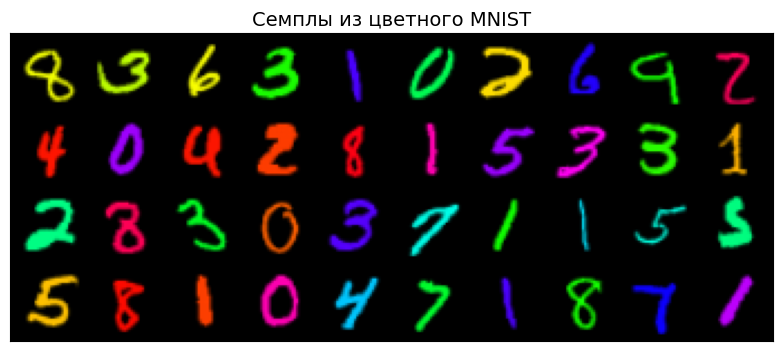

In [6]:
from torchvision.utils import make_grid

def remove_ticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=False,
        labelleft=False
    )

def remove_xticks(ax):
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False,
        left=True,
        labelleft=True
    )

def visualize_batch(img_vis, title='Семплы из цветного MNIST', nrow=10, ncol=4):
    img_grid = make_grid(img_vis, nrow=nrow)
    fig, ax = plt.subplots(1, figsize=(nrow, ncol))
    remove_ticks(ax)
    ax.set_title(title, fontsize=14)
    ax.imshow(img_grid.permute(1, 2, 0))
    plt.show()


visualize_batch(next(iter(train_dataloader))[0][:40])

## Предобученная диффузионная модель

Для дальнейшей работы с разного вида условной генерации нам понадобится предобученная **безусловная** диффузионная модель. Мы будем использовать простенькую архитектуру, которая была получена скрещиванием CUNet из того же [репозитория](https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/main/src/cunet.py) и части, кодирующей момент времени и метку класса, из SongUNet в [EDM](https://github.com/NVlabs/edm/blob/main/training/networks.py).

Такой выбор был мотивирован следующими наблюдениями:
* Готовые качественные архитектуры (те же SongUNet или DhariwalUNet) достаточно долго работают из-за своей глубины, что усложнит решение домашки, в которой, в основном, важны качественные результаты;
* Существующие имплементации этих архитектур достаточно абстрактно написаны, чтобы при первом знакомстве было удобно писать для них разного рода надстройки.

Архитектура CUNet представляет собой гораздо более легкую и неглубокую модель, за счет чего существенно ускоряет работу с ней и упрощает ее модификацию. Кодирование метки класса и момента времени везде более-менее одинаково (и включает в себя позиционное кодирование/positional encoding), поэтому выбор именно варианта из EDM не существенен.

Как и в семинаре, мы используем надстройку над архитектурой, которая делает все необходимые преобразования над входами: нормирование, взятие логарифма от уровня шума и т.д. Ее имплементация на этот раз взята из репозитория EDM, поэтому загрузка модели выглядит немного необычным образом. Можно не обращать внимания на устройство кода в следующих двух ячейках (небольшая часть кода из гитхаба EDM была изменена для удобства использования в ноутбуке).

In [7]:
!git clone https://github.com/NVlabs/edm
!cp edm/training/networks.py edm/training/networks_copy.py
!cp fid.py edm/fid.py

Cloning into 'edm'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 54 (delta 13), reused 13 (delta 13), pack-reused 20 (from 1)
Receiving objects: 100% (54/54), 2.13 MiB | 20.73 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [8]:
# эту ячейку можно будет перезапустить при обновлении имплементации в cunet.py
# функция возьмет изначальный файл, сохраненный в networks_copy.py, объединит его с cunet.py в файле networks.py

def append_code(in_files, out_file):
    lines = ['\n']
    for in_file in in_files:
        with open(in_file, 'r') as f:
            for line in f:
                lines.append(line)

    with open(out_file, 'w') as f:
        for line in lines:
            f.write(line)

append_code(['edm/training/networks_copy.py', 'cunet.py'], 'edm/training/networks.py')

In [9]:
import pickle
%cd edm
from training.networks import EDMPrecond
from torch_utils import misc
from dnnlib import util
%cd ..

model = EDMPrecond(img_resolution=32, img_channels=3, model_type='CUNet', noise_channels=128, base_factor=64, emb_channels=128)
model.eval().cuda()

with util.open_url('cunet.pkl') as f:
    data = pickle.load(f)
misc.copy_params_and_buffers(src_module=data['ema'], dst_module=model, require_all=True)

print(f"Модель имеет {sum(p.numel() for p in model.parameters())} параметров")

/kaggle/working/edm
/kaggle/working
Модель имеет 17548227 параметров


Возьмем слегка модифицированный код для генерации и визуализации из семинара и посмотрим, как работает безусловная модель:

In [10]:
def normalize(x):
    return x / x.abs().max(dim=0)[0][None, ...]

def velocity_from_denoiser(x, model, sigma, class_labels=None, error_eps=1e-4, stochastic=False, **model_kwargs):
    sigma = sigma[:, None, None, None]
    res = (-model(x, sigma, class_labels, **model_kwargs) + x) / (sigma + error_eps)

    if stochastic:
        res = res * 2

    return res

def get_timesteps(params):
    num_steps = params['num_steps']
    sigma_min, sigma_max = params['sigma_min'], params['sigma_max']
    rho = params['rho']

    step_indices = torch.arange(num_steps, device=params['device'])
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])]) # t_N = 0
    return t_steps

def sample_euler(model, noise, params, class_labels=None, **model_kwargs):
    num_steps = params['num_steps']
    vis_steps = params['vis_steps']
    t_steps = get_timesteps(params)
    x = noise * params['sigma_max']
    x_history = [normalize(noise)]
    with torch.no_grad():
        for i in range(len(t_steps) - 1):
            t_cur = t_steps[i]
            t_next = t_steps[i + 1]
            t_net = t_steps[i] * torch.ones(x.shape[0], device=params['device'])
            x = x + velocity_from_denoiser(x, model, t_net, class_labels=class_labels, stochastic=params['stochastic'], **model_kwargs) * (t_next - t_cur)
            if params['stochastic']:
                x = x + torch.randn_like(x) * torch.sqrt(torch.abs(t_next - t_cur) * 2 * t_cur)
            x_history.append(normalize(x).view(-1, 3, *x.shape[2:]))

    if 'cond' in model_kwargs.keys() and model_kwargs['cond'] is not None:
        x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]] + [model_kwargs['cond']]
    else:
        x_history = [x_history[0]] + x_history[::-(num_steps // (vis_steps - 2))][::-1] + [x_history[-1]]

    return x, x_history

def visualize_model_samples(model, params, class_labels=None, title='Семплы из модели', **model_kwargs):
    noise = torch.randn(40, 3, 32, 32).cuda()
    out, trajectory = sample_euler(model, noise, params, class_labels=class_labels, **model_kwargs)
    out = out * 0.5 + 0.5
    visualize_batch(out.detach().cpu(), title=title)

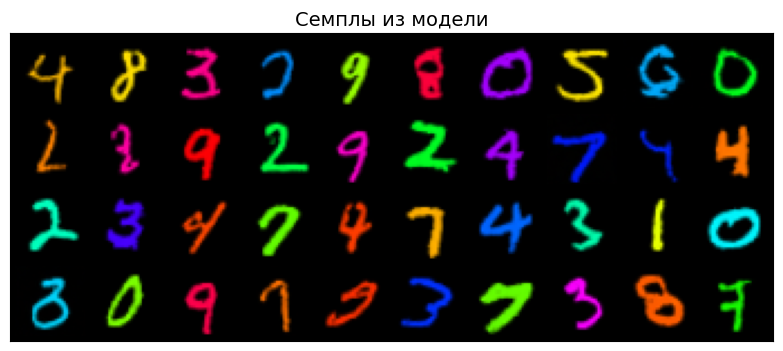

In [11]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 1,
    'stochastic': False
}
visualize_model_samples(model, params=sampling_params)

## Метрики качества генерации

Для домашки пригодится мерить качество моделей генерации. Как это сделать? Сходу не очень очевидно, если поставлена задача безусловной генерации, в которой нет ground truth сопоставления входа выходу. В такой ситуации стоит вспомнить, что задача генеративного моделирования, в первую очередь, состоит в приближении моделью распределения датасета. Разумной метрикой качества послужит какое-нибудь расстояние между распределением данных и распределением, порожденным генеративной моделью.


Распределениями мы, к сожалению, не располагаем, зато располагаем обучающим датасетом $\boldsymbol{X}_1, \ldots, \boldsymbol{X}_N$ и сгенерированной выборкой $\boldsymbol{Y}_1, \ldots, \boldsymbol{Y}_M$, поэтому нужно прибегать к оценке расстояния между распределениями по семплам. Беда состоит в том, что в высокой размерности классические методы восстановления плотности (метод гистограмм, ядерная оценка плотности (KDE) и т.д.), которые можно было бы применить к данным, чтобы потом получить две плотности $\hat{p}_{\boldsymbol{X}}$ и $\hat{p}_{\boldsymbol{Y}}$, работают очень плохо. Помимо этого, приблизить два набора данных некоторым простым распределением типа гауссовского тоже не самая корректная процедура: картиночные данные принципиально многомодальные, и такое приближение будет плохим.

На основе этих наблюдений была предложена следующая идея. Во-первых, данные можно "упростить", если перевести их в некоторое семантическое пространство с более осмысленным расстоянием, чем попиксельное $L_2$ между картинками. Есть шанс, что такое преобразование позволит сгруппировать данные и сделать распределение ближе к унимодальному (особенно, если при этом размерность снижается). В качестве такого пространства предлагается взять нейросеть, "видевшую все", обученную на классификацию какого-нибудь большого датасета, и взять ее признаковое пространство. Таким образом, наши новые данные — $f(\boldsymbol{X}_1), \ldots, f(\boldsymbol{X}_N)$ и $f(\boldsymbol{Y}_1), \ldots, f(\boldsymbol{Y}_M)$, где $f$ — функция, соответсвующая выходу нейросети перед классификационным слоем (который как раз отвечает за выделенные в объекте признаки). Исторически в качестве такой нейросети используется [InceptionV3](https://arxiv.org/abs/1512.00567), обученная на классификацию [ImageNet](https://www.image-net.org/).

Метрика [Fréchet Inception Distance (FID)](https://arxiv.org/abs/1706.08500), построенная на данной идее, заканчивает ее максимально просто. Оба набора данных приближаются гауссовскими распределениями с параметрами, равными соответствующим выборочным среднему и дисперсии:
$$
    \hat{p}_{f(\boldsymbol{X})}(\boldsymbol{z}) = \mathcal{N}(\boldsymbol{z} \mid \mu_{\boldsymbol{X}}, \Sigma_{\boldsymbol{X}}); \:\:\:\:\: \hat{p}_{f(\boldsymbol{Y})}(\boldsymbol{z}) = \mathcal{N}(\boldsymbol{z} \mid \mu_{\boldsymbol{Y}}, \Sigma_{\boldsymbol{Y}}),
$$
$$
    \mu_{\boldsymbol{X}} = \frac{1}{N} \sum\limits_{i = 1}^{N} f(\boldsymbol{X}_i), \:\:\:\: \Sigma_{\boldsymbol{X}} = \frac{1}{N} \sum\limits_{i = 1}^{N} \left(f(\boldsymbol{X}_i) - \mu_{\boldsymbol{X}} \right)\left(f(\boldsymbol{X}_i) - \mu_{\boldsymbol{X}} \right)^{\top}
$$
$$
    \mu_{\boldsymbol{Y}} = \frac{1}{M} \sum\limits_{j = 1}^{M} f(\boldsymbol{Y}_j), \:\:\:\: \Sigma_{\boldsymbol{Y}} = \frac{1}{M} \sum\limits_{j = 1}^{M} \left(f(\boldsymbol{Y}_j) - \mu_{\boldsymbol{Y}} \right)\left(f(\boldsymbol{Y}_j) - \mu_{\boldsymbol{Y}} \right)^{\top}.
$$

После таких манипуляций получились два распределения с явно заданной плотностью, между которыми уже можно вычислить некоторое расстояние. Одним из известных расстояний между распределениями является расстояние Вассерштейна, которое тесно связано с задачей оптимального транспорта и еще будет упомянуто в курсе. Сейчас же для нас важно то, что у такого расстояния есть явно заданная формула:

$$
    \mathcal{W}_2 (\mathcal{N}(\mu_{\boldsymbol{X}}, \Sigma_{\boldsymbol{X}}), \mathcal{N}(\mu_{\boldsymbol{Y}}, \Sigma_{\boldsymbol{Y}})) = \|\mu_{\boldsymbol{X}} - \mu_{\boldsymbol{Y}}\|^2 + \text{Tr}\left(\Sigma_{\boldsymbol{X}} + \Sigma_{\boldsymbol{Y}} - 2 \left(\Sigma_{\boldsymbol{X}} \Sigma_{\boldsymbol{Y}} \right)^{\frac{1}{2}} \right) = \|\mu_{\boldsymbol{X}} - \mu_{\boldsymbol{Y}}\|^2 + \|\sqrt{\Sigma_{\boldsymbol{X}}} - \sqrt{\Sigma_{\boldsymbol{Y}}} \|_{\text{F}}^2.
$$

Ее смысл очень простой: расстояние между двумя нормальными распределениями считается как квадрат расстояния между их средними плюс квадрат расстояния между корнями из матриц ковариации (в одномерном случае это квадрат расстояния между стандартными отклонениями).

Есть разные подходы к подсчету FID'a для разных задач, но в задаче безусловной генерации обычно считают то, насколько близки статистики сгенерированных изображений (часто берут 50000) к статистикам трейн датасета. Таким образом, мы измеряем то, насколько хорошо модель выучила распределение обучающих данных. Метрика достаточно чувствительна к количеству семплов и имеет тенденцию к недооценке реального расстояния, если взято небольшое количество семплов (проблемы во многом лезут из матрицы ковариаций, которая вырождена всегда, когда семплов меньше, чем их размерность). Здесь мы посчитаем FID на **10000** семплах, чтобы позже сравнивать с этим значением результаты условной генерации на тестовой выборке (размер которой как раз **10000**).

In [12]:
import os, shutil
from tqdm import tqdm
# сохраним семплы из модели для дальнейшего подсчета FID

def save_model_samples(name, model, params, batch_size, num_samples, **model_kwargs):
    os.makedirs(name, exist_ok=True)
    shutil.rmtree(name)
    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            noise = torch.randn(cur_batch_size, 3, 32, 32).cuda()

            out, trajectory = sample_euler(model, noise, params, **model_kwargs)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

save_model_samples('cunet_samples', model, sampling_params, batch_size=128, num_samples=10000)

10000 images saved: 100%|██████████| 10000/10000 [04:03<00:00, 40.99it/s]


In [13]:
# возьмем реализацию подсчета FID из EDM
%cd edm
from fid import calculate_inception_stats, calculate_fid_from_inception_stats
from dnnlib.util import open_url
%cd ..

def calc_fid(image_path, ref_path, num_expected, batch):
    with open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

fid = calc_fid('cunet_samples', 'cmnist_train.npz', num_expected=10000, batch=128)
print('Модель имеет FID = %.4g' % (fid,))

/kaggle/working/edm
/kaggle/working
Loading Inception-v3 model...
Loading images from "cunet_samples"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:20<00:00,  3.95batch/s]


Модель имеет FID = 2.273


Конечно, для того, чтобы получить представление о том, каковы типичные значения метрики FID на том или ином датасете, нужна практика (или читать статьи). Выбранная нами модель далеко не идеальна, на цветном MNIST можно достигать значений, меньших FID=1.0. Тем не менее, FID~2 тоже неплох, но в основном он нужен нам для референса.

## Парные задачи переноса стиля

На лекции/семинаре мы посмотрели на то, как обуславливать диффузионные модели (в том числе, предобученные безусловные) на метку класса. Наша цель в этой части домашки — попробовать обучить диффузионную модель для решения парной задачи переноса стиля.

Задача переноса стиля (перевода между доменами) ставит перед собой построение отображения $G(\mathbf{X})$ между двумя распределениями $p$ и $q$: то есть, такого отображения, что если $\mathbf{X} \sim p$, то $G(\mathbf{X}) \sim q$. Любое ли отображение с таким свойством подойдет? Нет, потому что в таком случае мы будем, например, считать решением задачи превращения кошки в собаку отображение $G$, которое переводит кошку в произвольную собаку, не имеющую ничего общего со входным изображением. Нам же хотелось бы гарантировать связь между входом и выходом. Дальше на курсе мы формализуем эту идею с помощью задачи оптимального транспорта.

Парными же считаются задачи, в которых задан датасет из пар $(\mathbf{X}_0, \mathbf{Y})$, где $\mathbf{X}_0 \sim p$, $\mathbf{Y} \sim q$, а пары задают искомое отображение $G$.

Типичным классом парных задач являются **обратные** задачи, в которых объект $\mathbf{Y}$ получен из объекта $\mathbf{X}$ путем удаления части его информации, а целью является восстановление исходного объекта. К таким задачам относятся повышение разрешения (super-resolution), деблюринг, дорисовывание (inpaiting), восстановление картинки после JPEG сжатия, и т.д. С одной из именно таких задач по выбору мы будем здесь работать.

## ControlNet: обуславливание для решения парных задач

Как было обсуждено ранее, чтобы обусловить диффузионную модель на произвольную переменную $\mathbf{Y}$, зависимую с $\mathbf{X}$, достаточно подавать ей ее на вход и обучать на стандартный Denoising Score Matching лосс:
$$
    \int\limits_{0}^{T} \beta_t \, \mathbb{E} \|\, \text{D}^{\theta}_t(\mathbf{X}_t | \mathbf{Y}) - \mathbf{X}_0 \,\|^2 \mathrm{d} t \rightarrow \min\limits_{\theta}.
$$

Таким образом, все, что нужно сделать на практике, — придумать архитектуру, которая будет принимать на вход шумную картинку, уровень шума и дополнительное условие $\mathbf{Y}$, и обучить модель на указанный выше функционал.

Представим теперь ситуацию, в которой нам доступна предобученная безусловная диффузионная модель. Содержащихся в ней знаний достаточно для того, чтобы сгенерировать любой объект из распределения данных $p$. Единственное, что ей не хватает, — умение учитывать дополнительный вход. Архитектура ControlNet ([гитхаб](https://github.com/lllyasviel/ControlNet)) добавляет в архитектуру UNet дополнительный кодировщик, который переводит дополнительный вход в латентное пространство, а затем подмешивает его в декодировщик наряду с латентным кодом шумного изображения. В применении к архитектуре CUNet, обновленная архитектура ControlNet будет выглядеть следующим образом (если в какой-то блок приходят две стрелочки, это значит, что входы нужно просуммировать):

Кодировщик в CUNet состоит из первого преобразующего слоя $\textbf{inc}$ и четырех блоков со снижением размерности и увеличением числа каналов $\textbf{down}_i$. Декодировщик же имеет выходной слой $\textbf{inc}$ и 4 слоя, повышающих размерность и уменьшающих число каналов. Каждый такой слой состоит из нормализации $\textbf{adain}_i$, принимающей на вход закодированные метку класса и уровень шума, и из сверточного блока $\textbf{up}_i$.

Чтобы превратить данную архитектуру в ControlNet, нужно заморозить все веса исходной модели и скопировать (с весами) кодировщик для того, чтобы переводить поданное условие в скрытое представление. Вся процедура кодирования условия идейно повторяет кодирование шумного изображения. Тем не менее, есть один важный нюанс, — использование "нулевых" сверток $\textbf{zero}_i$. Чтобы не портить работу исходной замороженной модели, все промежуточные версии закодированного условия $\textbf{c}_i$ подаются в $1 \times 1$ свертку, заинициализированную нулевыми весами, и только потом складываются с соответствующей активацией $\textbf{x}_i$. Таким образом, при инициализации модель должна реализовывать такую же функцию, как изначальный CUNet.

Чтобы новый кодировщик учился быстрее, он инициализируется весами кодировщика шумного изображения. Кодировщик же этот привык видеть шумные изображения, а не бесшумное условие. Эта разница нивелируется тем, что ему на вход подается сумма шумного изображения с условием, прошедшим через нулевую свертку. Таким образом, на начальном этапе в новый кодировщик подается объект, практически не отличающийся от шумного изображения, с которым он привык работать.

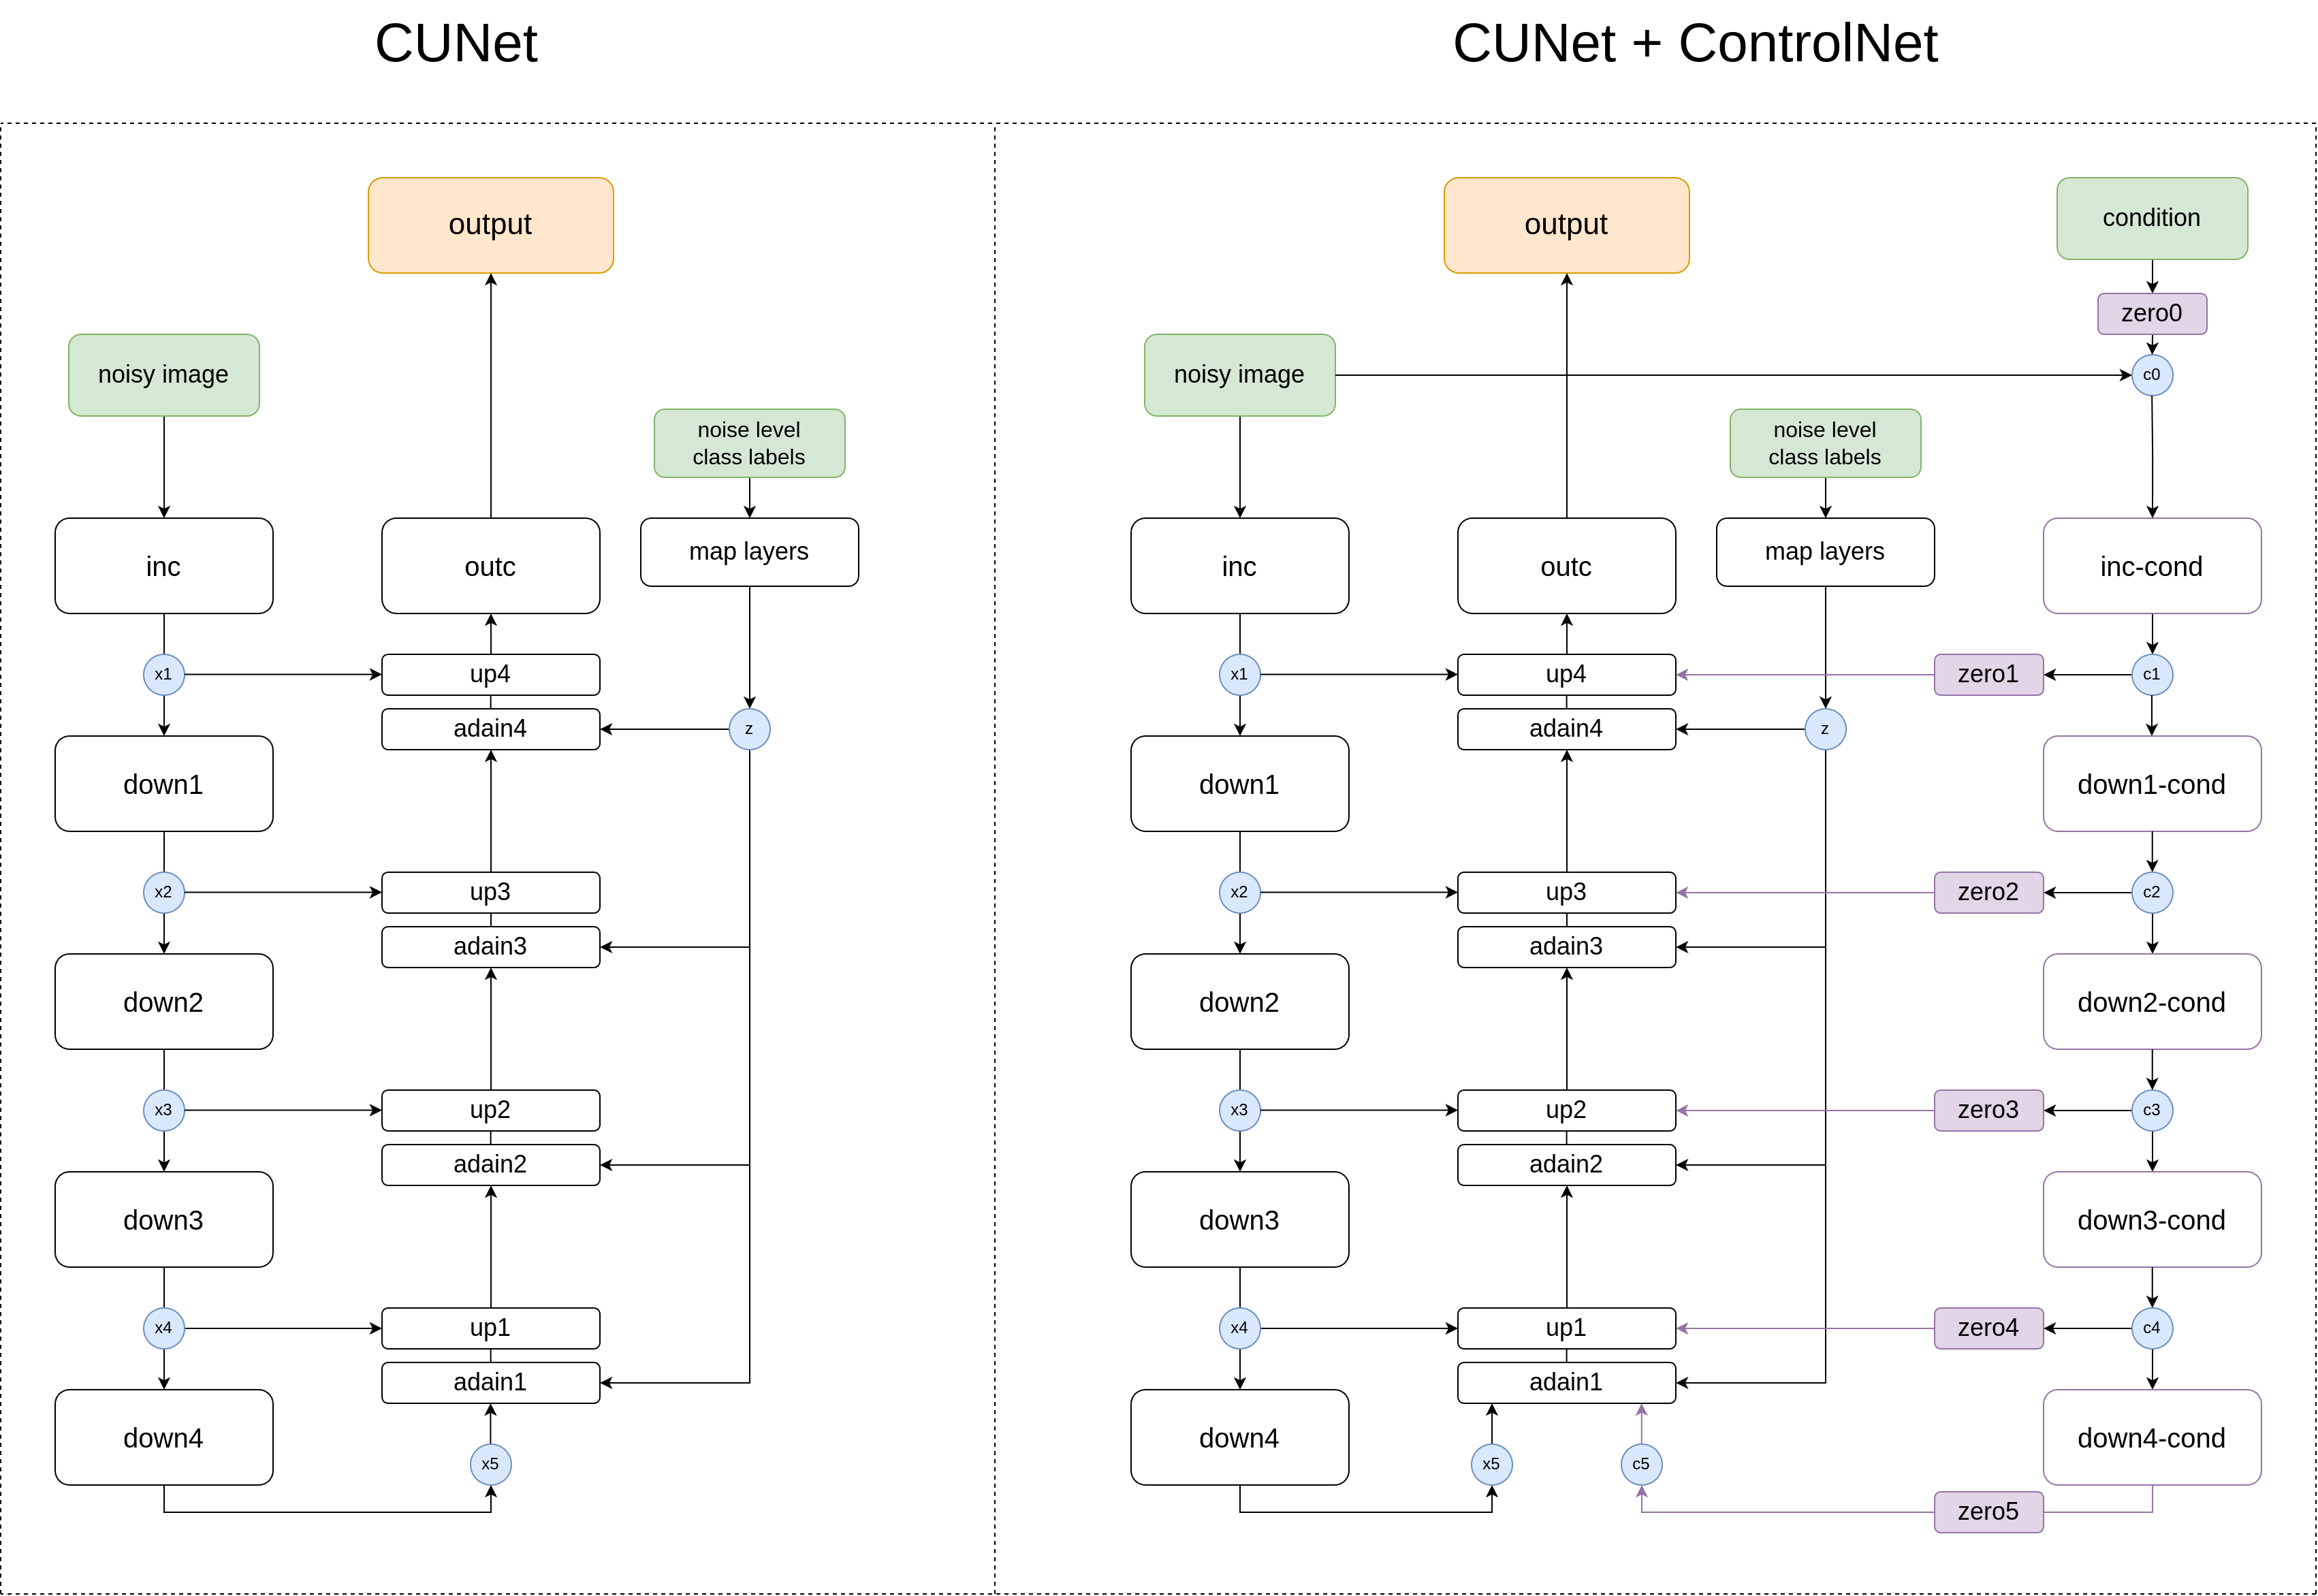

## Задача 1 (0.4 балла)

Имплементируйте ControlNet в файле *cunet.py*. После этого нужно будет перезапустить ячейку, в которой *cunet.py* объединяется с *networks.py*.

In [14]:
from edm.training.networks import ControlCUNet

In [15]:
class CondEDMPrecond(nn.Module):
    def __init__(self, model, sigma_data=0.5):
        super().__init__()
        self.sigma_data = sigma_data
        self.model = model

    def forward(self, x, sigma, cunet, class_labels=None, cond=None,):
        sigma = sigma.reshape(-1, 1, 1, 1)

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        if cond is None:
            F_x = self.model((c_in * x), c_noise.flatten(), cond=None, class_labels=class_labels)
        else:
            F_x = self.model((c_in * x), c_noise.flatten(), cond=(cond / self.sigma_data), class_labels=class_labels)

        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x


In [34]:
# model представляет собой обертку EDMPrecond над архитектурой
# в ControlNet же мы передаем именно внутреннюю архитектуру, содержащуюся в поле model
controlnet = ControlCUNet(model.model)
cond_model = CondEDMPrecond(controlnet)
cond_model = cond_model.train().cuda()

## Задача 2 (0.4 балла).

Обучите ControlNet на одной из следующих обратных задач: повышение разрешения (сжатие хотя бы до $12 \times 12$), деблюринг (гауссовский блюринг с размером ядра $\geq 7$ и $\sigma \geq 2$) или дорисовывание (с удалением хотя бы половины пикселей картинки). Проверьте, что модель работает на визуальном уровне: семплы должны быть качественными и должны быть консистентными с поданным в модель условием. Сгенерируйте несколько семплов из модели, обусловив ее на одно и то же испорченное изображение, но начав генерацию из разных шумов.

Небольшое замечание: указанных в коде 50 эпох должно хватить, суммарно обучение не должно занять больше двух часов. Примерно через 5-10 эпох (м.б. быстрее, зависит от задачи) должны появиться первые признаки консистентности выхода со входом (на уровне структуры изображения, цвет зачастую начинает переноситься позже).

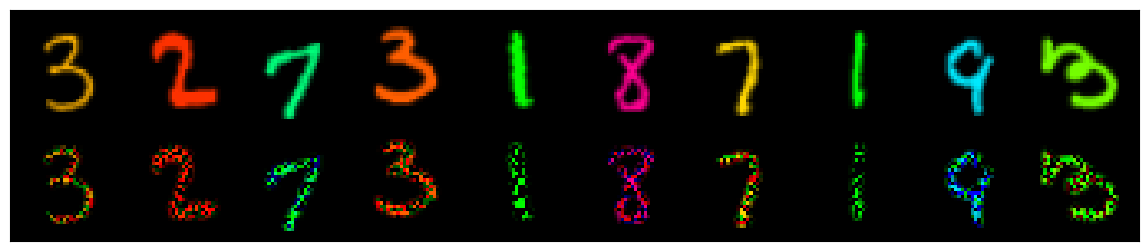

In [33]:
# здесь должно быть все, что нужно
import torchvision.transforms as transforms

def corruption(x):
    mask = (torch.rand_like(x) > 0.5).float()
    return mask * x

def visualize_corruption(batch, corruption):
    batch_corr = corruption(batch)
    batch_cat = torch.cat((batch, batch_corr), dim=0)
    image_grid = make_grid(batch_cat, nrow=len(batch))

    fig, ax = plt.subplots(figsize=(3 * len(batch), 3))
    remove_ticks(ax)
    ax.imshow(image_grid.permute(1, 2, 0))
    plt.show()

visualize_corruption(next(iter(train_dataloader))[0][:10], corruption)

In [35]:
def visualize_denoising(log_imgs, ax, n_pictures=4):
    img_vis = torch.cat((
        normalize(log_imgs['cond'][:n_pictures]),
        normalize(log_imgs['clear_images'][:n_pictures]),
        normalize(log_imgs['noisy_images'][:n_pictures]),
        normalize(log_imgs['denoised_images'][:n_pictures])),
        dim=0
    )
    img_grid = make_grid(img_vis, nrow=n_pictures) * 0.5 + 0.5
    ax.imshow(img_grid.permute(1, 2, 0).detach().cpu())

def visualize_training(model, loss_history, log_imgs, sampling_params, n_pictures=4, n_pictures_sampling=4, cond=None):
    fig, ax = plt.subplot_mosaic([['loss', 'denoising'],
                                   ['sampling', 'sampling']],
                                  figsize=(11, 9), layout="constrained")

    # loss visualization
    ax['loss'].plot(np.arange(len(loss_history)), loss_history)
    ax['loss'].grid(True)
    ax['loss'].set_title('Лосс на обучении', fontsize=17)
    ax['loss'].set_xlabel('Итерация', fontsize=14)
    ax['loss'].tick_params(labelsize=13)

    #denoising visualization
    remove_ticks(ax['denoising'])
    visualize_denoising(log_imgs, ax['denoising'], n_pictures=n_pictures)
    ax['denoising'].set_title('Денойзинг с помощью модели', fontsize=17)

    #sampling
    noise = torch.randn_like(log_imgs['clear_images'][:n_pictures_sampling])

    remove_ticks(ax['sampling'])
    _, trajectory = sample_euler(model, noise, params=sampling_params, cond=cond[:n_pictures_sampling])

    trajectory = torch.cat(trajectory, dim=0) * 0.5 + 0.5
    trajectory = trajectory.reshape(len(trajectory) // n_pictures_sampling, n_pictures_sampling, *trajectory.shape[-3:]).permute(1, 0, 2, 3, 4).reshape(-1, *trajectory.shape[-3:])
    img_grid = make_grid(trajectory, nrow=len(trajectory) // n_pictures_sampling)

    #sampling visualization
    ax['sampling'].imshow(img_grid.permute(1, 2, 0).detach().cpu())
    ax['sampling'].set_title('Семплы из модели', fontsize=17)

    plt.show()

In [36]:
class EDMLoss:
    def __init__(self, mean=0.0, std=1.0, sigma_data=0.5):
        self.mean = mean
        self.std = std
        self.sigma_data = sigma_data

    def __call__(self, net, images, cond=None, labels=None, augment_pipe=None):
        rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
        sigma = (rnd_normal * self.std + self.mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        n = torch.randn_like(images) * sigma
        D_yn = net(images + n, sigma, labels, cond=cond)
        loss = (weight * (D_yn - images) ** 2).mean()
        log_imgs = {
            'cond':            cond.detach(),
            'clear_images':    images.detach(),
            'noisy_images':    ((images + n)).detach(),
            'denoised_images': D_yn.detach()
        }
        return loss, log_imgs

In [37]:
from tqdm import tqdm
from IPython.display import clear_output
import copy

def train(model, opt, loss_fn, corruption, train_dataloader, test_dataloader, n_epochs, sampling_params, eval_every=100):
    loss_history = []
    iter = 0
    with tqdm(total=len(train_dataloader) * n_epochs) as pbar:
        for epoch in range(n_epochs):
            for batch in train_dataloader:
                model.train()
                opt.zero_grad()
                x = (batch[0] * 2 - 1).cuda()
                y = corruption(x)
                loss, log_imgs = loss_fn(model, x, cond=y)
                loss.backward()
                loss_history.append(loss.item())
                opt.step()

                if iter % eval_every == 0:
                    model.eval()
                    clear_output(wait=True)
                    visualize_training(model, loss_history, log_imgs, sampling_params, cond=y)

                pbar.update(1)
                pbar.set_description('Loss: %.4g' % loss.item())
                iter += 1

    return model

In [38]:
from functools import partial

params = [p for p in cond_model.parameters() if p.requires_grad]
print(f'Модель имеет {sum(p.numel() for p in params)} обучаемых параметров')

opt = torch.optim.Adam(params, lr=1e-3)
loss_fn = EDMLoss(-1.2, 1.2, 0.5)

Модель имеет 10022668 обучаемых параметров


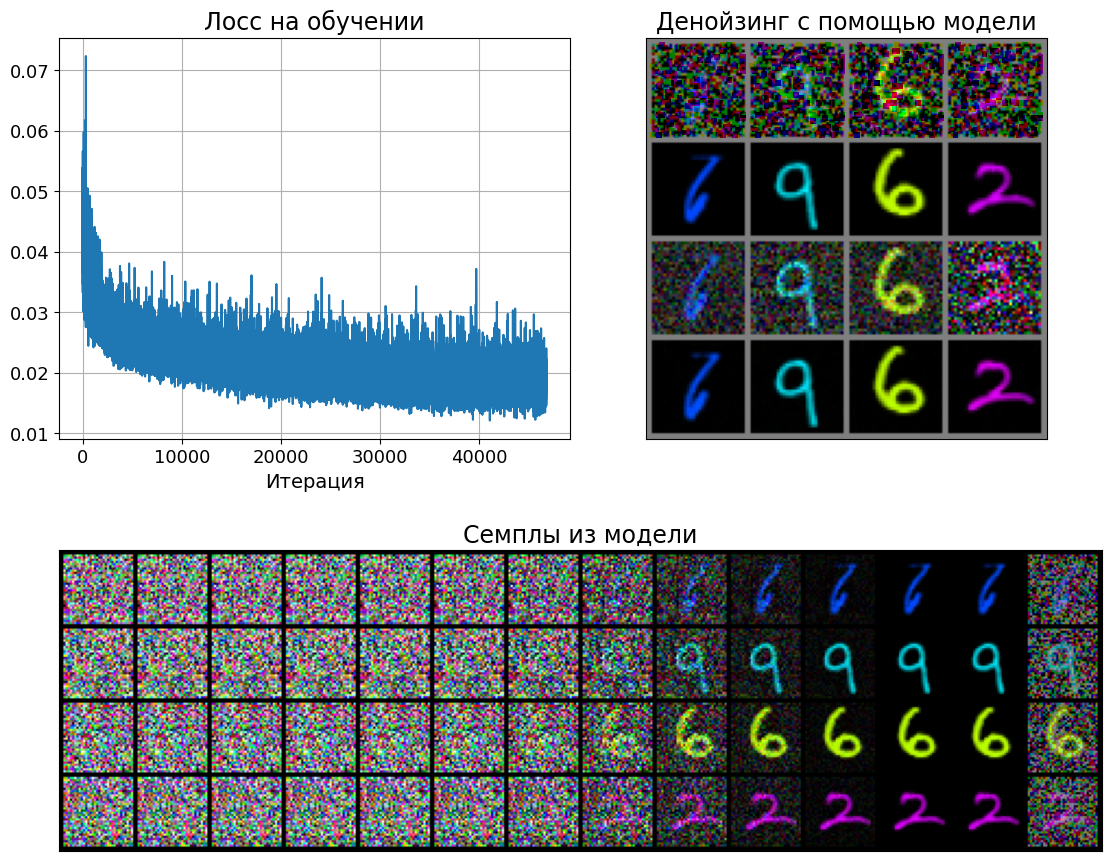

Loss: 0.01823: 100%|██████████| 46900/46900 [1:17:59<00:00, 10.02it/s]


In [39]:
sampling_params = {
    'device': 'cuda',
    'sigma_min': 0.02,
    'sigma_max': 80.0,
    'num_steps': 50,
    'rho': 7.0,
    'vis_steps': 12,
    'stochastic': False
}

cond_model = train(cond_model, opt, loss_fn, corruption, train_dataloader, test_dataloader, n_epochs=50, sampling_params=sampling_params)

## Задача 3 (0.2 балла)

Оцените качество работы модели численно. Возьмите тестовый датасет, преобразуйте изображения оттуда с помощью выбранной деградации и сгенерируйте по одному семплу, подав в модель соответствующее условие. Посчитайте две метрики:

* Консистентность: правда ли, что сгенерированный при условии $\mathbf{Y}$ семпл удовлетворяет $\text{corrupt}(\mathbf{X}) = \mathbf{Y}$? Здесь самым простым вариантом может быть посчитать среднюю по датасету $L_1$ метрику $\| \text{corrupt}(\mathbf{X}) - \mathbf{Y} \|_1$ и отнормировать ее на суммарное число пикселей, чтобы получилось интерпретируемое число, которое можно сравнить с длиной интервала, в котором лежат пиксели изображения: 1 в случае $[0, 1]$ и 2 в случае $[-1, 1]$.
* FID между полученными 10000 семплами и трейн датасетом (чьи статистики хранятся в *cmnist_train.npz*). Успехом здесь можно считать FID меньший, чем у безусловной модели, в идеале $< 2.0$ (почему такое в теории возможно?)

Тут возьмём другую функцую, для искажения изображений, потому что удаление пикселей зависит от сгенерированного в функции шума.

In [70]:
def corruption_gaus(x):
    return transforms.GaussianBlur(7, 2)(x)

In [73]:
def check_consistancy(model, params, dataloader, corruption, **model_kwargs):
    l1_dist = 0.0
    with tqdm(total=len(dataloader)) as pbar:
        for batch, _ in dataloader:
            cond = corruption(batch).to(params['device']) * 2 - 1
            noise = torch.randn_like(cond)
            out, _ = sample_euler(model, noise, params, cond=cond, **model_kwargs)
            corrupt_out = corruption(out)
            l1_dist += torch.abs(corrupt_out - cond).sum().item()
            pbar.update(1)
    return l1_dist
dist = check_consistancy(cond_model, sampling_params, test_dataloader, corruption_gaus)
print(dist / (test_dataloader.batch_size * len(test_dataloader) * 32 ** 2 * 3))

0.19510801778730566


Ну то есть в среднем чиселки отклоняются на 0.2 при максимальном отклонение 2.

In [62]:
def save_model_samples(name, model, params, dataloader, batch_size, num_samples, **model_kwargs):
    os.makedirs(name, exist_ok=True)
    shutil.rmtree(name)
    os.makedirs(name, exist_ok=True)
    count = 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            noise = torch.randn(cur_batch_size, 3, 32, 32).cuda()
            cond = corruption(next(dataloader)[:cur_batch_size][0] * 2 - 1).to(params['device'])

            out, trajectory = sample_euler(model, noise, params, cond=cond, **model_kwargs)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))

save_model_samples('controlnet_samples', cond_model, sampling_params, iter(test_dataloader), batch_size=test_dataloader.batch_size, num_samples=10000)

10000 images saved: 100%|██████████| 10000/10000 [05:37<00:00, 29.66it/s]


In [74]:
fid = calc_fid('controlnet_samples', 'cmnist_train.npz', num_expected=10000, batch=128)
print('Модель имеет FID = %.4g' % (fid,))

Loading Inception-v3 model...
Loading images from "controlnet_samples"...
Calculating statistics for 10000 images...


100%|██████████| 79/79 [00:19<00:00,  3.97batch/s]


Модель имеет FID = 1.276


Как и хотели, получили FID < 2.0

Почему такое возможно: в данном случае модель принимает достаточно много информации о структуре изображения, поэтому полученные сэмплы будут явно лучше, чем сэмплы безусловной диффузионки (распределение так себе изображений и хороших должны отличаться)